In [32]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "azerty92")

with GraphDatabase.driver(URI, auth=AUTH) as driver: 
    driver.verify_connectivity()

In [ ]:
# afficher le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).

def q1(tx):
    query = """
    MATCH (r:Resource)-[m:MENTIONS]->(e:Event)-[:TAKES_PLACE]->(c:Country)
    RETURN e.date AS jour,
        c.name AS pays,
        r.originalLanguage AS langue_article,
        COUNT(DISTINCT(r)) AS nb_ressources,
        COUNT(DISTINCT(e)) AS nb_event
    """
    results = list(tx.run(query))
    results = [line.data() for line in results]
    return pd.DataFrame(results)
    # or: return [record["name"] for record in result]

with driver.session(database="gdelt") as session:
    data_q1 = session.execute_read(q1)

data_q1.head(10)

In [19]:
# pour un pays donné en paramètre, affichez les évènements qui y ont eu place triées par le nombre de mentions (tri décroissant);
# permettez une agrégation par jour/mois/année

def q2(tx, country):
    query = """
        MATCH p = (c:Country {name: $country})<-[:TAKES_PLACE]-(e:Event)<-[m:MENTIONS]-()
        RETURN 	m.date.year AS Year, m.date.month AS Month, m.date.day AS Day, e.globalEventID AS Event, COUNT(m) AS nb_mention
        ORDER BY nb_mention DESC
        """
    results = list(tx.run(query, country=country))
    results = [line.data() for line in results]
    return pd.DataFrame(results)
    # or: return [record["name"] for record in result]

with driver.session(database="gdelt") as session:
    data_q2 = session.execute_read(q2, "Russia")

data_q2.head(10)

,Year,Month,Day,Event,nb_mention
0,2022,1,21,1024249059,603
1,2022,1,26,1025019366,531
2,2022,1,20,1024063602,513
3,2022,1,19,1023873272,477
4,2022,1,28,1025400292,424
5,2022,1,23,1024548719,422
6,2022,1,26,1025027143,417
7,2022,1,30,1025696603,399
8,2022,1,26,1025022952,389
9,2022,1,10,1022500642,385


In [20]:
# pour une source de donnés passée en paramètre (gkg.SourceCommonName)
# affichez les thèmes, personnes, lieux dont les articles de cette sources parlent
# ainsi que le nombre d’articles et le ton moyen des articles (pour chaque thème/personne/lieu);
# permettez une agrégation par jour/mois/année.

def q3(tx, source_name):
    query = """
        MATCH (s:Source {name:$source_name})-[:PUBLISH]->(r:Resource)-[:MENTIONS]->(e:Event)<-[:ACTS_IN]-(a),
        (e)-[:TAKES_PLACE]->(c:Country),
        (r)-[:HAS]->(t)
        RETURN r.date.year AS Year, 
                r.date.month AS Month, 
                r.date.day AS Day,
                t.name AS Theme, 
                a.name AS Personne, 
                c.name AS Pays, 
                COUNT(r) AS nb_article, 
                AVG(r.tone) AS ton_moyen
        ORDER BY ton_moyen DESC
        """
    results = list(tx.run(query, source_name=source_name))
    results = [line.data() for line in results]
    return pd.DataFrame(results)
    # or: return [record["name"] for record in result]

with driver.session(database="gdelt") as session:
    data_q3 = session.execute_read(q3, "lemonde.fr")

data_q3.head(10)

,Year,Month,Day,Theme,Personne,Pays,nb_article,ton_moyen
0,2022,1,27,DEMOCRACY,FRANCE,France,1,5.012531
1,2022,1,27,TAX_FNCACT_ORGANIZERS,FRANCE,France,1,5.012531
2,2022,1,28,MEDIA_SOCIAL,CAIRO,Egypt,3,3.663501
3,2022,1,28,TAX_WORLDLANGUAGES,CAIRO,Egypt,3,3.663501
4,2022,1,28,USPEC_POLITICS_GENERAL1,CAIRO,Egypt,3,3.663501
5,2022,1,28,NEW_CONSTRUCTION,CAIRO,Egypt,3,3.663501
6,2022,1,28,EPU_ECONOMY,CAIRO,Egypt,3,3.663501
7,2022,1,28,TAX_WORLDLANGUAGES_BAMBARA,CAIRO,Egypt,3,3.663501
8,2022,1,28,MEDIA_MSM,CAIRO,Egypt,3,3.663501
9,2022,1,28,TAX_FNCACT_JOURNALIST,CAIRO,Egypt,3,3.663501


In [29]:
# étudiez l’évolution des relations entre deux pays (specifies en paramètre) au cours de l’année.
# Vous pouvez vous baser sur la langue de l’article, le ton moyen des articles,
# les themes plus souvent citées, les personalités ou tout element qui vous semble pertinent.

def q4(tx, country_1, country_2):
    query = """
        MATCH (c1:Country {name:$country_1})<-[:TAKES_PLACE]-(e1)<-[:MENTIONS]-(r),
        (c2:Country {name:$country_2})<-[:TAKES_PLACE]-(e2)<-[:MENTIONS]-(r)
        WHERE r.date IS NOT NULL
        RETURN c1.name AS country_1,
                c2.name AS country_2,
                r.date.year AS year,
                r.date.month AS month, 
                r.date.day AS day,
                AVG(r.tone) AS avg_tone
        """
    results = list(tx.run(query, country_1=country_1,country_2=country_2))
    results = [line.data() for line in results]
    return pd.DataFrame(results)
    # or: return [record["name"] for record in result]

with driver.session(database="gdelt") as session:
    data_q4 = session.execute_read(q4, "Ukraine", "Russia")

data_q4.head(10)

,country_1,country_2,year,month,day,avg_tone
0,Ukraine,Russia,2022,1,18,-3.139273
1,Ukraine,Russia,2022,1,25,-3.164314
2,Ukraine,Russia,2022,1,23,-2.776710
3,Ukraine,Russia,2022,1,24,-3.225609
4,Ukraine,Russia,2022,1,15,-3.397937
5,Ukraine,Russia,2022,1,26,-3.890370
6,Ukraine,Russia,2022,1,30,-3.068011
7,Ukraine,Russia,2022,1,19,-2.699120
8,Ukraine,Russia,2022,1,17,-3.619873
9,Ukraine,Russia,2022,1,21,-3.160827


In [34]:
data_q4["date"] = pd.to_datetime(data_q4[['year', 'month', 'day']])
data_q4.head()

,country_1,country_2,year,month,day,avg_tone,date
0,Ukraine,Russia,2022,1,18,-3.139273,2022-01-18
1,Ukraine,Russia,2022,1,25,-3.164314,2022-01-25
2,Ukraine,Russia,2022,1,23,-2.776710,2022-01-23
3,Ukraine,Russia,2022,1,24,-3.225609,2022-01-24
4,Ukraine,Russia,2022,1,15,-3.397937,2022-01-15


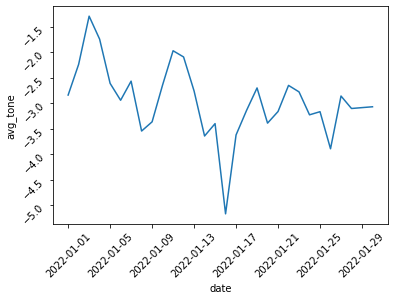

In [35]:
ax = sns.lineplot(x="date", y="avg_tone", data=data_q4)

ax.tick_params(rotation=45)

plt.show()